# Quantum Black-Box Chaos Experiment 1 — Kicked Top

**Goal:**  
Reuse the black-box chaos indicators validated on the classical Duffing oscillator  
(LZ, RR, DEPH, IFSP, K01 + piecewise onset detection) and apply them to a **quantum kicked top**.

- Chaos knob: **kick strength** \( k \) (analogous to γ in Duffing)  
- Model: **quantum kicked top**  
- Observable: time series of \( \langle J_z \rangle (t) \) over discrete kicks  
- Metrics: **K01, LZ, RR, DEPH, IFSP**  
- Extra quantum diagnostic: **Loschmidt echo decay rate** vs k  

This notebook is **Stage 2** of the programme:

1. Stage 1 (done): Classical Duffing benchmark with black-box metrics.  
2. Stage 2 (here): Quantum kicked top with the same metrics.  
3. Stage 3 (future): More quantum models / experimental time series.


In [1]:
# If you don't have qutip / scipy yet, uncomment and run this once:
# !pip install qutip scipy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import qutip as qt
from scipy.signal import hilbert

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

# Quantum kicked top parameters
J = 20                 # total spin (dimension = 2J+1)
DIM = int(2*J + 1)

T_KICKS = 1024         # number of kicks (time-series length)
N_SEEDS = 5            # "ensemble" size – different initial coherent states

K_GRID = np.linspace(0.5, 6.0, 25)   # chaos parameter (analogous to γ)
P = np.pi / 2                         # rotation angle (standard choice)

DT = 1.0              # effective Δt between kicks (for Hilbert-based metrics)
RNG = np.random.default_rng(1234)


In [3]:
# 2) Quantum kicked top model: angular momentum operators + Floquet operator

def kicked_top_operators(J):
    """Returns angular momentum operators Jx, Jy, Jz for spin J."""
    j = J
    Jx = qt.jmat(j, 'x')
    Jy = qt.jmat(j, 'y')
    Jz = qt.jmat(j, 'z')
    return Jx, Jy, Jz

Jx, Jy, Jz = kicked_top_operators(J)

def floquet_operator(k, p=P):
    """Single-kick Floquet operator U(k) for the quantum kicked top.

    U = exp(-i k Jz^2 / (2J+1)) * exp(-i p Jy)
    """
    j = J
    H_twist = (k / (2*j + 1)) * (Jz @ Jz)   # nonlinear twist around z
    U_twist = (-1j * H_twist).expm()
    H_rot = p * Jy                           # rotation around y
    U_rot = (-1j * H_rot).expm()
    return U_twist * U_rot


In [4]:
# 3) Initial states and observable

def random_spin_coherent(J, rng, theta=None, phi=None):
    """Build a spin-coherent state |theta, phi> on the Bloch sphere.
    If theta/phi are None, sample them randomly (uniform on the sphere)."""
    if theta is None:
        theta = np.arccos(2*rng.random() - 1)   # cos(theta) uniform in [-1,1]
    if phi is None:
        phi = 2*np.pi * rng.random()
    return qt.spin_coherent(J, theta, phi)

OBS = Jz  # we measure <Jz> per kick

def generate_initial_states(J, n_seeds, rng):
    states = []
    for _ in range(n_seeds):
        psi0 = random_spin_coherent(J, rng)
        states.append(psi0)
    return states

INITIAL_STATES = generate_initial_states(J, N_SEEDS, RNG)
len(INITIAL_STATES), INITIAL_STATES[0].dims


(5, [[41], [1]])

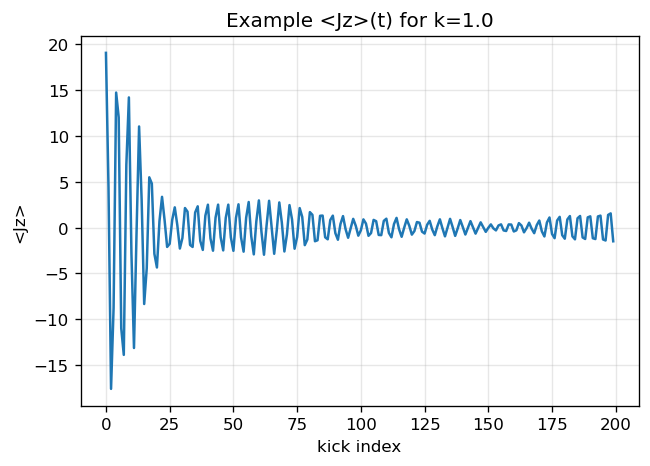

In [5]:
# 4) Simulation: time series of <Jz> over kicks

def simulate_kicked_top(k, psi0, n_kicks=T_KICKS):
    """Simulate the kicked top for n_kicks, starting from psi0.
    Returns:
        t: array of times (kick indices * DT)
        y: array of <Jz>(t) expectation values
    """
    U = floquet_operator(k)
    psi = psi0
    t = np.arange(n_kicks) * DT
    y = np.empty(n_kicks, dtype=float)

    for n in range(n_kicks):
        y[n] = qt.expect(OBS, psi)
        psi = U * psi  # apply one kick

    return t, y

# quick smoke test for a single k and state
t_test, y_test = simulate_kicked_top(k=1.0, psi0=INITIAL_STATES[0], n_kicks=200)
plt.plot(t_test, y_test)
plt.xlabel("kick index")
plt.ylabel("<Jz>")
plt.title("Example <Jz>(t) for k=1.0")
plt.grid(alpha=0.3)
plt.show()


In [6]:
# 5) Black-box metrics utilities

import numpy.linalg as LA

def quantize_to_uint8(x):
    """Standardise and map to 0..255 (uint8) for LZ."""
    x = np.asarray(x, float)
    xz = (x - np.mean(x)) / (np.std(x) + 1e-12)
    xc = np.clip(xz, -4, 4)
    q = (((xc + 4) / 8) * 255).astype(np.uint8)
    return q

def lz_complexity(seq):
    """LZ76-style complexity on a uint8 sequence.
    Returns normalised complexity c(n)/(n/log2 n)."""
    s = bytes(np.asarray(seq, dtype=np.uint8).ravel())
    n = len(s)
    if n < 2:
        return 0.0
    c = 0
    i = 0
    while i < n:
        L = 1
        while i + L <= n and s[i:i+L] in s[:i]:
            L += 1
        c += 1
        i += L
    return c / (n / np.log2(n))

def recurrence_rate(x, m=3, tau=None, radius_mult=0.1):
    """Estimate recurrence rate from a delay embedding."""
    x = np.asarray(x, float)
    if tau is None:
        tau = 1
    N = len(x) - (m-1)*tau
    if N <= 1:
        return np.nan
    Y = np.zeros((N, m))
    for i in range(m):
        Y[:, i] = x[i*tau : i*tau + N]
    dists = LA.norm(Y[:, None, :] - Y[None, :, :], axis=-1)
    dvec = dists[np.triu_indices(N, k=1)]
    if len(dvec) == 0:
        return np.nan
    med = np.median(dvec)
    r = radius_mult * med if med > 0 else np.mean(dvec + 1e-12)
    rec = (dists < r).astype(float)
    rr = rec[np.triu_indices(N, k=1)].mean()
    return rr

def phase_dephasing_half_life(x, dt, max_time=None):
    """Dephasing half-life via Hilbert transform and moving average."""
    x = np.asarray(x, float)
    z = hilbert(x)
    ph = np.unwrap(np.angle(z))
    if max_time is None:
        max_time = dt * len(x)
    c = np.exp(1j * ph)
    N = len(c)
    w = max(5, int(0.05 * N))
    if w >= N:
        return np.nan
    cs = np.cumsum(c)
    cs = np.concatenate([[0], cs])
    ma = (cs[w:] - cs[:-w]) / w
    t_ma = np.arange(len(ma)) * dt
    mag = np.abs(ma)
    if len(mag) == 0:
        return np.nan
    m0 = mag[0]
    target = 0.5 * m0
    idx = np.where(mag <= target)[0]
    if len(idx) == 0:
        return np.nan
    return t_ma[idx[0]]

def if_spread(x, dt):
    """Instantaneous frequency spread from Hilbert phase."""
    x = np.asarray(x, float)
    z = hilbert(x)
    ph = np.unwrap(np.angle(z))
    w = np.diff(ph) / dt
    if len(w) == 0:
        return np.nan
    return np.std(w)

def zero_one_test(x, c_samples=100):
    """Simplified 0–1 test for chaos."""
    x = np.asarray(x, float)
    N = len(x)
    n = np.arange(N)
    discard = int(0.1 * N)
    x = x[discard:]
    n = n[discard:]
    N = len(x)
    if N < 50:
        return np.nan
    Ks = []
    for _ in range(c_samples):
        c = np.pi * np.random.rand()
        pc = np.cumsum(x * np.cos(c * n))
        qc = np.cumsum(x * np.sin(c * n))
        M = pc**2 + qc**2
        M = M - np.mean(M)
        nn = n - np.mean(n)
        num = np.sum(M * nn)
        den = np.sum(nn**2)
        Kc = num / (den + 1e-12)
        Ks.append(Kc)
    return float(np.mean(Ks))

def piecewise_linear_one_break(x, y, min_points=4):
    """Brute-force one-breakpoint piecewise linear model."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    N = len(x)
    if N < 2 * min_points:
        return dict(bp_idx=None, params=None)
    best_ssr = np.inf
    best_bp = None
    best_params = None
    for bp in range(min_points, N - min_points):
        xl, yl = x[:bp], y[:bp]
        xr, yr = x[bp:], y[bp:]
        pl = np.polyfit(xl, yl, 1)
        pr = np.polyfit(xr, yr, 1)
        yl_hat = np.polyval(pl, xl)
        yr_hat = np.polyval(pr, xr)
        ssr = np.sum((yl - yl_hat)**2) + np.sum((yr - yr_hat)**2)
        if ssr < best_ssr:
            best_ssr = ssr
            best_bp = bp
            best_params = (pl, pr)
    return dict(bp_idx=best_bp, params=best_params)


In [7]:
# 6) Wrapper: compute all metrics for a single time series

EMBED_M = 3
REC_RADIUS_MULT = 0.1

def compute_all_metrics(y, dt):
    """Compute K01, LZ, RR, DEPH, IFSP for a time series y."""
    k01 = zero_one_test(y, c_samples=50)
    q = quantize_to_uint8(y)
    lz = lz_complexity(q)
    rr = recurrence_rate(y, m=EMBED_M, tau=None, radius_mult=REC_RADIUS_MULT)
    deph = phase_dephasing_half_life(y, dt)
    ifs = if_spread(y, dt)
    return dict(K01=k01, LZ=lz, RR=rr, DEPH=deph, IFSP=ifs)


In [8]:
# 7) Parameter sweep over kick strength k

results = []
for ki, k in enumerate(K_GRID):
    print(f"Simulating k={k:.3f} ({ki+1}/{len(K_GRID)})")
    for s, psi0 in enumerate(INITIAL_STATES):
        t, y = simulate_kicked_top(k, psi0, n_kicks=T_KICKS)
        metrics = compute_all_metrics(y, DT)
        metrics.update(dict(k=k, seed=s))
        results.append(metrics)

df_q = pd.DataFrame(results)
df_q.head()


Simulating k=0.500 (1/25)
Simulating k=0.729 (2/25)
Simulating k=0.958 (3/25)
Simulating k=1.188 (4/25)
Simulating k=1.417 (5/25)
Simulating k=1.646 (6/25)
Simulating k=1.875 (7/25)
Simulating k=2.104 (8/25)
Simulating k=2.333 (9/25)
Simulating k=2.562 (10/25)
Simulating k=2.792 (11/25)
Simulating k=3.021 (12/25)
Simulating k=3.250 (13/25)
Simulating k=3.479 (14/25)
Simulating k=3.708 (15/25)
Simulating k=3.938 (16/25)
Simulating k=4.167 (17/25)
Simulating k=4.396 (18/25)
Simulating k=4.625 (19/25)
Simulating k=4.854 (20/25)
Simulating k=5.083 (21/25)
Simulating k=5.312 (22/25)
Simulating k=5.542 (23/25)
Simulating k=5.771 (24/25)
Simulating k=6.000 (25/25)


,K01,LZ,RR,DEPH,IFSP,k,seed
0,29.333974,4.843750,0.018552,3.0,0.048575,0.5,0
1,36.486140,2.734375,0.239140,2.0,0.767626,0.5,1
2,41.848454,2.968750,0.309750,44.0,1.641756,0.5,2
3,6.812168,2.939453,0.302595,25.0,1.139398,0.5,3
4,7.067185,3.994141,0.024296,208.0,0.187577,0.5,4


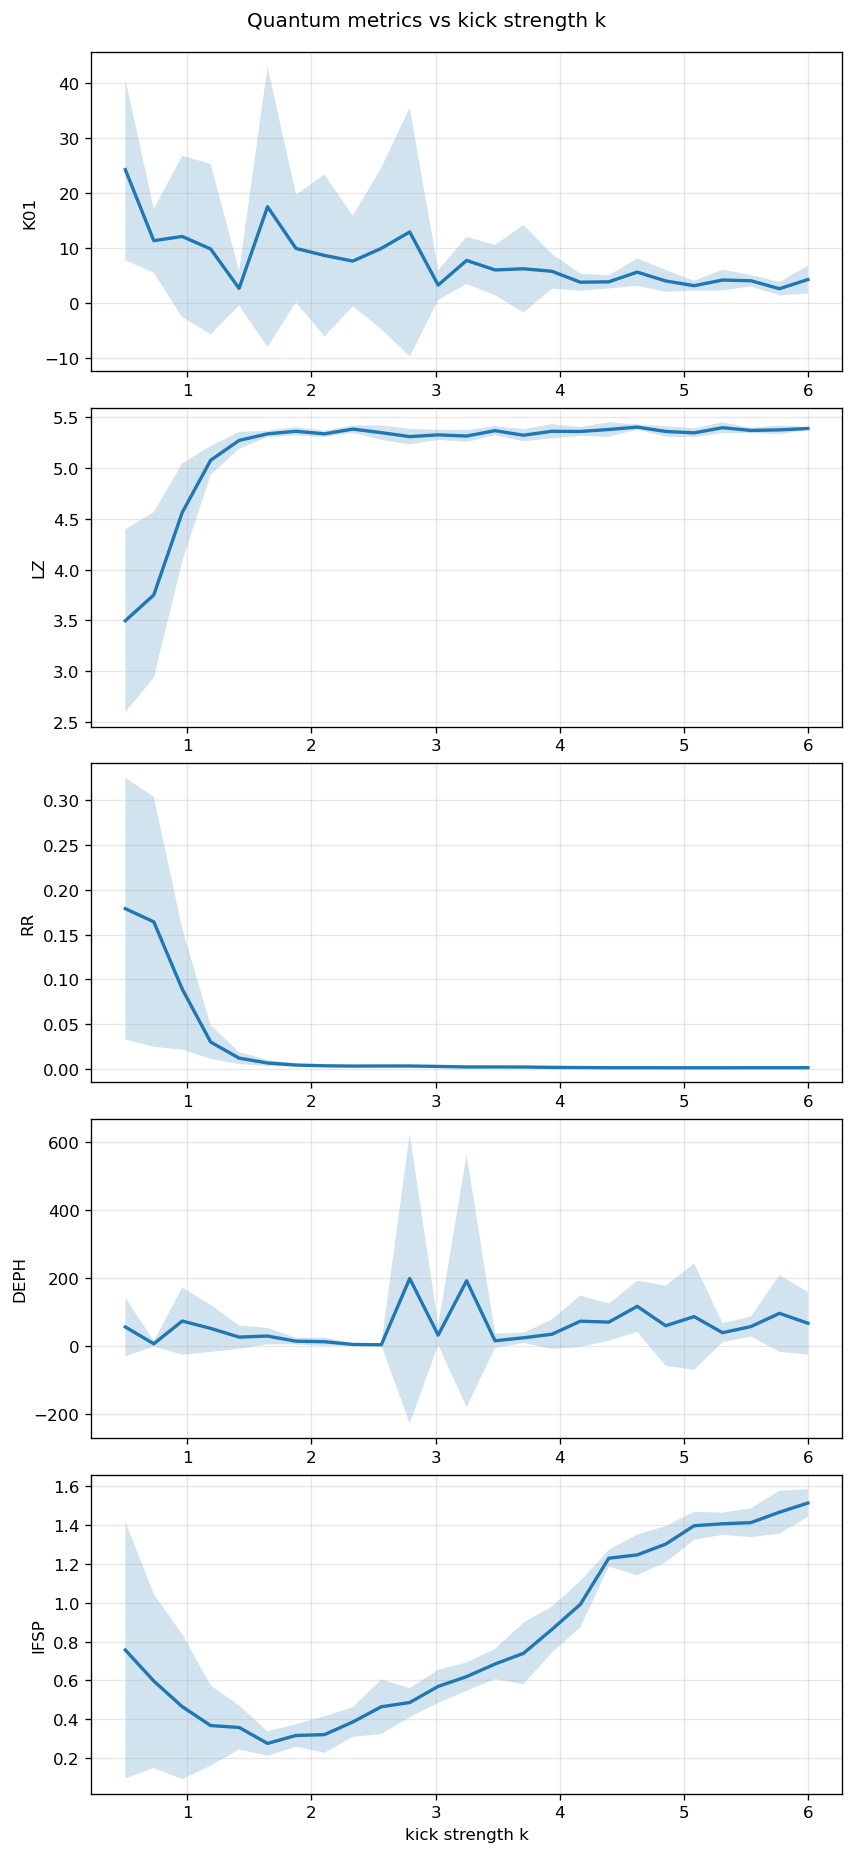

In [9]:
# 8) Aggregate over seeds and plot metrics vs k

agg_q = df_q.groupby('k', as_index=False).agg(['mean', 'std'])

flat_cols = []
for col in agg_q.columns:
    if isinstance(col, tuple):
        flat_cols.append('_'.join([c for c in col if c]))
    else:
        flat_cols.append(str(col))
agg_q.columns = flat_cols

metrics = ['K01', 'LZ', 'RR', 'DEPH', 'IFSP']

fig, axes = plt.subplots(len(metrics), 1, figsize=(7, 3*len(metrics)), constrained_layout=True)
x = agg_q['k']

for i, m in enumerate(metrics):
    mu = agg_q.get(f'{m}_mean', None)
    sd = agg_q.get(f'{m}_std', None)
    if mu is None:
        continue
    mu = mu.to_numpy()
    sd = sd.to_numpy()
    mask = np.isfinite(mu)
    axes[i].plot(x[mask], mu[mask], lw=2)
    axes[i].fill_between(x[mask], mu[mask]-sd[mask], mu[mask]+sd[mask], alpha=0.2)
    axes[i].set_ylabel(m)
    axes[i].grid(alpha=0.3)
axes[-1].set_xlabel('kick strength k')

plt.suptitle("Quantum metrics vs kick strength k", y=1.02)
plt.show()


In [10]:
# 9) Onset detection via piecewise linear fit in k

breakpoints_q = {}
x = agg_q['k'].to_numpy()

for m in metrics:
    y = agg_q.get(f'{m}_mean', None)
    if y is None:
        breakpoints_q[m] = np.nan
        continue
    y = y.to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 6:
        breakpoints_q[m] = np.nan
        continue
    xb, yb = x[mask], y[mask]
    best = piecewise_linear_one_break(xb, yb, min_points=4)
    bp_k = xb[best['bp_idx']] if best['bp_idx'] is not None else np.nan
    breakpoints_q[m] = bp_k

breakpoints_q


{'K01': np.float64(1.6458333333333333),
 'LZ': np.float64(1.4166666666666665),
 'RR': np.float64(1.4166666666666665),
 'DEPH': np.float64(2.7916666666666665),
 'IFSP': np.float64(1.875)}

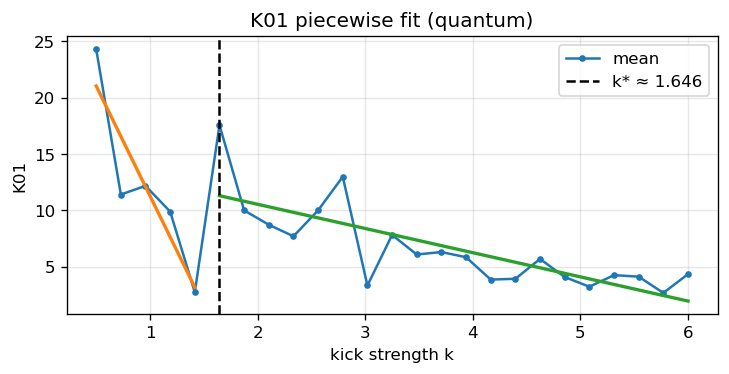

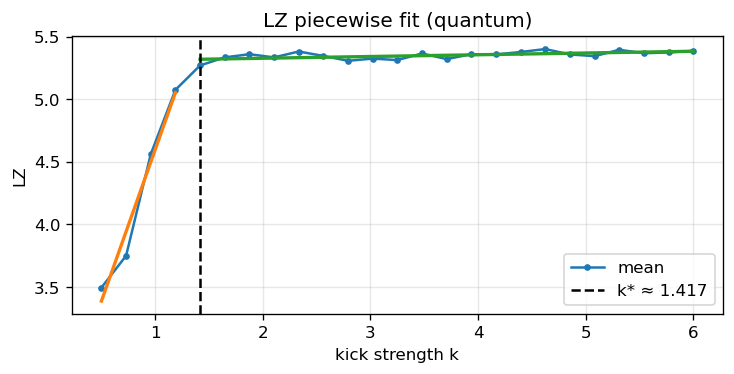

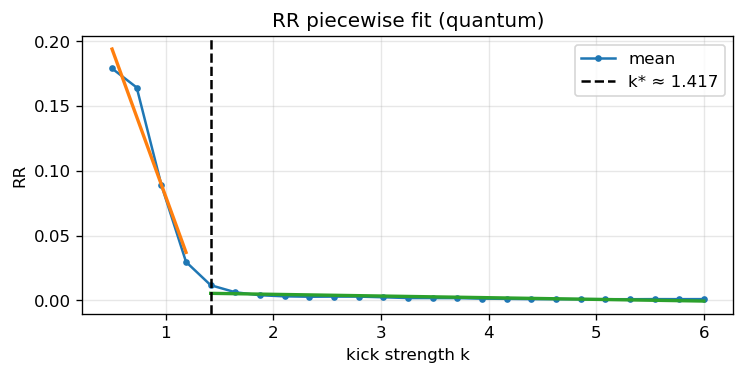

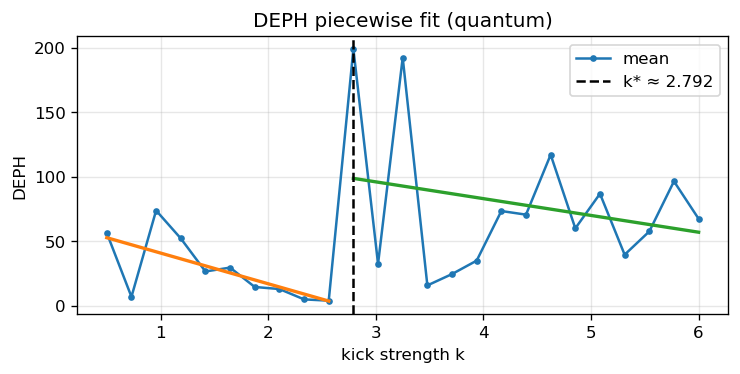

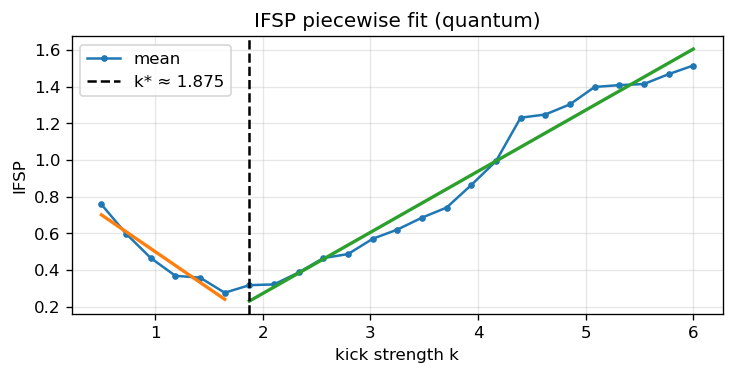

In [11]:
# 10) Visualise piecewise fits for each metric

import os
os.makedirs("results_quantum", exist_ok=True)

for m in metrics:
    y = agg_q.get(f'{m}_mean', None)
    if y is None:
        continue
    y = y.to_numpy()
    x = agg_q['k'].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 6:
        print(f"{m}: not enough points to fit.")
        continue

    xb, yb = x[mask], y[mask]
    best = piecewise_linear_one_break(xb, yb, min_points=4)

    plt.figure(figsize=(7,3))
    plt.plot(xb, yb, '-o', ms=3, label='mean')

    if best['bp_idx'] is not None:
        pl, pr = best['params']
        bp = best['bp_idx']
        xl = xb[:bp]
        xr = xb[bp:]
        yl_hat = np.polyval(pl, xl)
        yr_hat = np.polyval(pr, xr)
        plt.plot(xl, yl_hat, lw=2)
        plt.plot(xr, yr_hat, lw=2)
        plt.axvline(xb[bp], ls='--', color='k', label=f"k* ≈ {xb[bp]:.3f}")
        plt.legend(loc='best')

    plt.xlabel("kick strength k")
    plt.ylabel(m)
    plt.title(f"{m} piecewise fit (quantum)")
    plt.grid(alpha=0.3)

    fname = f"results_quantum/piecewise_quantum_{m}.png"
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()


Computing Loschmidt echo vs k ...


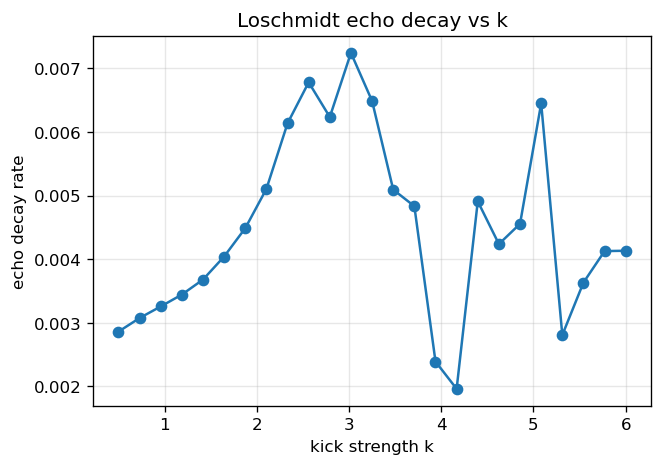

In [13]:
# 11) Loschmidt echo as quantum-chaos benchmark

def loschmidt_echo_time_series(k, delta_k, psi0, n_kicks=T_KICKS):
    """
    Compute Loschmidt echo L(n) between evolution with k and k+delta_k.
    """
    U = floquet_operator(k)
    U_pert = floquet_operator(k + delta_k)

    psi = psi0
    psi_pert = psi0

    L = np.empty(n_kicks, dtype=float)
    for n in range(n_kicks):
        psi = U * psi
        psi_pert = U_pert * psi_pert

        # OLD (causing error):
        # overlap = (psi.dag() * psi_pert)[0, 0]

        # NEW (works with your qutip version):
        overlap = psi.overlap(psi_pert)          # returns a complex scalar
        L[n] = np.abs(overlap)**2
    return np.arange(n_kicks), L


def echo_decay_rate(L, n_fit=(10, 200)):
    """Fit log(L(n)) ~ a + b n => decay rate = -b."""
    n = np.arange(len(L))
    n0, n1 = n_fit
    n_seg = n[n0:n1]
    L_seg = L[n0:n1]
    eps = 1e-12
    y = np.log(L_seg + eps)
    b, a = np.polyfit(n_seg, y, 1)
    return -b

delta_k = 0.01
echo_results = []

print("Computing Loschmidt echo vs k ...")
for k in K_GRID:
    psi0 = INITIAL_STATES[0]  # one reference initial state
    n_echo, L = loschmidt_echo_time_series(k, delta_k, psi0, n_kicks=T_KICKS)
    rate = echo_decay_rate(L, n_fit=(10, 200))
    echo_results.append(dict(k=k, echo_rate=rate))

df_echo = pd.DataFrame(echo_results)

plt.figure()
plt.plot(df_echo['k'], df_echo['echo_rate'], '-o')
plt.xlabel('kick strength k')
plt.ylabel('echo decay rate')
plt.title('Loschmidt echo decay vs k')
plt.grid(alpha=0.3)
plt.show()


In [14]:
# 12) Save breakpoints & echo results

bp_table_q = pd.DataFrame([
    {'metric': m, 'k_break': v} for m, v in breakpoints_q.items()
])

os.makedirs("results_quantum", exist_ok=True)
bp_table_q.to_csv("results_quantum/quantum_breakpoints.csv", index=False)
df_echo.to_csv("results_quantum/loschmidt_echo_vs_k.csv", index=False)

bp_table_q


,metric,k_break
0,K01,1.645833
1,LZ,1.416667
2,RR,1.416667
3,DEPH,2.791667
4,IFSP,1.875000


### 13) Quick interpretation notes

- The black-box metrics (K01, LZ, RR, DEPH, IFSP) now live on a **quantum** time series ⟨Jz⟩(t).
- The piecewise-linear detector gives an onset k* for each metric.
- The Loschmidt echo decay rate is a **traditional quantum-chaos diagnostic**:
  - faster decay → stronger sensitivity to perturbations → more “chaotic” regime.

Questions to explore:

1. Does the region where echo decay rate increases align with the k*-cluster from the black-box metrics?
2. How does this quantum k*-band compare conceptually to the γ*-band in the Duffing experiment?
3. Can DEPH here be interpreted as a **classical-like analogue of decoherence time** in this quantum model?

This notebook, together with the Duffing benchmark, gives you a full classical–quantum bridge for the black-box chaos indicators.
